In [114]:
import jax
import jax.numpy as jnp
import genjax
from genjax import gen
from genjax import ChoiceMapBuilder as C
genjax.pretty()
from genjax import ExactDensity, Pytree
from tensorflow_probability.substrates import jax as tfp
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
tfd = tfp.distributions

    
""" Distribution Utilities """ 

unicat = lambda x: jnp.ones(len(x)) / len(x)
normalize = lambda x: x / jnp.sum(x)

""" Define Distributions """

@Pytree.dataclass
class LabeledCategorical(ExactDensity):
    def sample(self, key, probs, labels, **kwargs):
        cat = tfd.Categorical(probs=normalize(probs))
        cat_index = cat.sample(seed=key)
        return labels[cat_index]

    def logpdf(self, v, probs, labels, **kwargs):
        w = jnp.log(jnp.sum(normalize(probs) * (labels==v)))
        return w

@Pytree.dataclass
class UniformCategorical(ExactDensity):
    def sample(self, key, labels, **kwargs):
        cat = tfd.Categorical(probs=jnp.ones(len(labels)) / len(labels))
        cat_index = cat.sample(seed=key)
        return labels[cat_index]

    def logpdf(self, v, labels, **kwargs):
        probs = jnp.ones(len(labels)) / len(labels)
        logpdf = jnp.log(probs)
        w = logpdf[0]
        return w
    
labcat = LabeledCategorical()
uniformcat = UniformCategorical()

In [193]:
def animate(frames, fps):
    fig, ax = plt.subplots()
    def update(frame):
        ax.clear()
        ax.set_title(f"Frame {frame}")
        ax.imshow(frames[frame])
    ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=1000/fps)
    return ani

# def construct_frames(choices):
#     xs = choices["dynamics", ..., "x"]
#     ys = choices["dynamics", ..., "y"]  
#     blinks = choices["dynamics", ..., "blink"]
#     frames = jnp.zeros((100, 64, 64))
    

#     for i, blink in enumerate(blinks):
#         if blink == 1:
#             x_obs = int(xs[i])
#             y_obs = int(ys[i])
#             for x in range(x_obs-2, x_obs+2):
#                 for y in range(y_obs-2, y_obs+2):
#                     frames = frames.at[i, y, x].set(1)
#     return frames

In [363]:
@gen
def init_firefly(scene_size):
    init_x = genjax.uniform(1., float(scene_size.const)) @ "x"
    init_y = genjax.uniform(1., float(scene_size.const)) @ "y"
    blink_rate = genjax.uniform(0.1, 0.25) @ "blink_rate"
    blinking = 0
    return (init_x, init_y, blink_rate, blinking) 

@genjax.scan(n=100)
@gen 
def step_firefly(firefly, carry):
    x, y, blink_rate, _ = firefly
    new_x = genjax.normal(x, 1.) @ "x"
    new_y = genjax.normal(y, 1.) @ "y"
    blink = genjax.flip(blink_rate) @ "blink"
    carry.append([new_x, new_y, blink])
    return (new_x, new_y, blink_rate, blink), carry

@gen
def single_firefly_model(scene_size):
    firefly = init_firefly(scene_size) @ "init"
    firefly, chain = step_firefly(firefly, []) @ "dynamics"
    return (firefly, chain)

@jax.jit
def calculate_glow(coordinate, glow_size, scene_size):
    # Create a grid of coordinates
    y, x = jnp.mgrid[0:64, 0:64]
    
    # Calculate distances from the given coordinate
    distances = jnp.sqrt((x - coordinate[1])**2 + (y - coordinate[0])**2)
    
    # Calculate glow values (assuming a Gaussian-like glow)
    glow_values = jnp.exp(-(distances**2) / (2 * glow_size**2))
    
    return glow_values

def render_frame(xs, ys, blinks, scene_size, base_glow_size):
    # Extract x, y coordinates and blinking values for the current frame
    coordinates = jnp.stack([xs, ys], axis=-1)
    glow_sizes = base_glow_size * blinks
    v_calculate_glow = jax.vmap(calculate_glow, in_axes=(0, 0, None))

    # Calculate glows for all fireflies
    glow_values = v_calculate_glow(coordinates, glow_sizes, scene_size)
    jax.debug.breakpoint()
    # Create a grid to accumulate glow values
    glow_grid = jnp.zeros((64, 64))

    # Function to update glow_grid for each firefly
    def accumulate_glow(carry, values):
        glow_grid = carry + values
        return glow_grid, None

    # Use scan to iteratively accumulate glow values
    final_glow_grid = jax.lax.scan(accumulate_glow, glow_grid, glow_values)[0]
    
    return final_glow_grid

@gen
def observe_fireflies(xs, ys, blinks, scene_size, base_glow_size=3):
    # Vectorize the render_frame function over all timesteps
    v_render_frame = jax.vmap(render_frame, in_axes=(0, 0, 0, None, None))
    rendered = v_render_frame(xs, ys, blinks, scene_size, base_glow_size)
    noisy_obs = genjax.normal(rendered, 0.01) @ "obs"
    return noisy_obs

@gen 
def multifirefly_model(scene_size, max_fireflies):
    n_fireflies = labcat(unicat(max_fireflies), max_fireflies) @ "n_fireflies"
    masks = max_fireflies <= n_fireflies
    multifirefly_model = genjax.MaskCombinator(single_firefly_model).vmap(in_axes=(0, None))
    fireflies = multifirefly_model(masks, scene_size) @ "fireflies"

    masks = jnp.where(fireflies.flag, masks, 0)
    chain = jnp.array(fireflies.value[1]).squeeze()
    xs, ys, blinks = chain[0, :, :], chain[1, :, :], chain[2, :, :] # N, T
    xs = xs[masks, :]
    ys = ys[masks, :]
    blinks = blinks[masks, :]
    observations = observe_fireflies(xs, ys, blinks, scene_size.const) @ "observations"
    return fireflies, observations


In [364]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
fireflies = jnp.arange(1, 5)
scene_size = genjax.Pytree.const(64)
steps = jnp.arange(10)

multi_model_jit = jax.jit(multifirefly_model.simulate)
tr = multi_model_jit(subkey, (scene_size, fireflies,))

key, subkey = jax.random.split(key)
tr = multi_model_jit(subkey, (scene_size, fireflies,))

Entering jdb:
--KeyboardInterrupt--
Entering jdb:


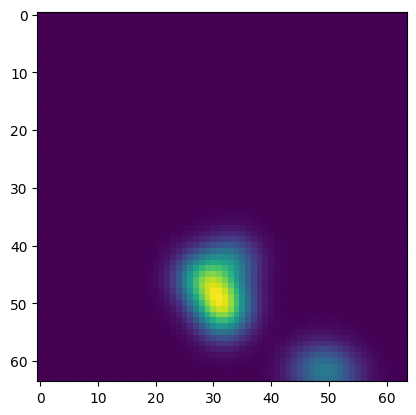

In [362]:
plt.imshow(tr.get_sample()["observations", "obs"].sum(axis=0))

In [347]:
obs = tr.get_retval()[1]

In [348]:
obs.va

GenerativeFunctionClosure(...)

In [249]:
ret = tr.get_retval()
vals = jnp.array(ret.value[1]).squeeze()[:, ret.flag == 1, :]
vals[2, 2]

AttributeError: 'tuple' object has no attribute 'value'

In [152]:
vals = chm["fireflies", ..., "dynamics", ..., "x"]
vals.value[jnp.where(vals.flag == 1)]

<jax.Array float32(3, 100) ≈2.6e+01 ±1.1e+01 [≥9.5, ≤4.5e+01] nonzero:300>

In [75]:
chm["dynamics", ..., "blink"]

<jax.Array int32(100,) [≥0, ≤1] zero:82 nonzero:18
  <Arrayviz rendering>
>